In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import os

def get_data(index):
        row = pd.read_csv('train.csv').iloc[index]
        id_num = row['id']
        split = 'train' if id_num <=4800 else 'validation' if id_num <=4900 else 'test'

        eeg_path = os.path.join(
                ".", row['task'], split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv'
        )

        ten_trials_df = pd.read_csv(eeg_path)
        ten_trials_df['Time'] -= ten_trials_df['Time'].iloc[0]

        trial_num = int(row['trial'])
        samples_per_trial = 1750 if row['task'].lower() == 'ssvep' else 2250
        one_trial_df = ten_trials_df.iloc[(trial_num-1)*samples_per_trial : trial_num*samples_per_trial] # shape(1750, 8ch+othercolumns)
        return ten_trials_df, one_trial_df, row


def get_filtered(data, low, high, order=4, fs=250, padlen=1749):
    b, a = butter(order, [low, high], btype='band', fs=fs)
    filtered = filtfilt(b, a, data, method='pad',padlen=padlen)
    return filtered

def get_highpass_filtered(data, cutoff, fs=250, order=5, padlen=1749):
    b, a = butter(order, cutoff, btype='high', fs=fs)
    y = filtfilt(b, a, data, method='pad', padlen=padlen)
    return y

def get_iirnotch_filtered(data, notchfreq, Q=30, fs=250, padlen=1749):
    b, a = iirnotch(notchfreq/(fs/2), Q)
    y = filtfilt(b,a, data, method='pad', padlen=padlen)
    return y


def get_frequency(filtered, fs=250):
    freqs = np.fft.rfftfreq(len(filtered), d=1/fs)
    fft_vals = np.abs(np.fft.rfft(filtered))
    return freqs, fft_vals


FREQUENCIES = {
        'Left': 10,    # ---> 0
        'Right': 13,   # ---> 1
        'Forward': 7,  # ---> 2
        'Backward': 8  # ---> 3
    }


In [92]:
index = 2639  #((((2400 --> 4799)))) SSVEP   #2430 (battery drop peak drop) # 2448 (peak)
fs =250

# in case of stimulus extraction
ten_trials_df, one_trial_df, row = get_data(index)
data = one_trial_df
low = FREQUENCIES[row['label']]- fs/len(data) # Hz
high = FREQUENCIES[row['label']]+ fs/len(data) #40.0  # Hz

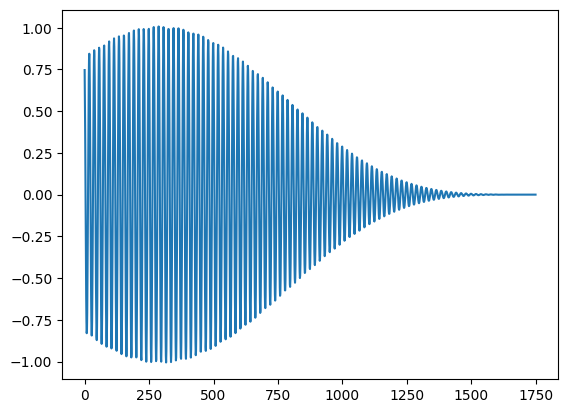

In [126]:
plt.plot(filtered)

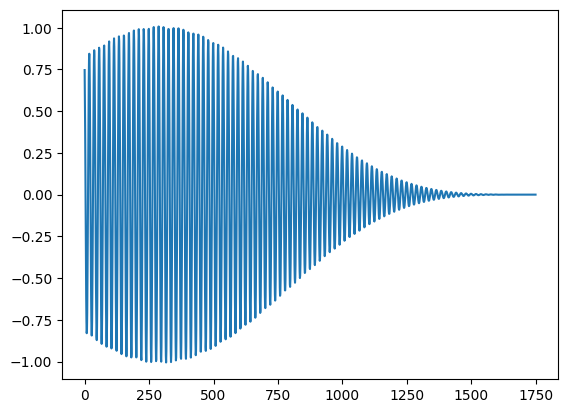

In [127]:
plt.plot(np.fft.irfft(np.fft.rfft(filtered)))

In [165]:
len(np.linspace(-10,10,1000))
1000/20

50.0

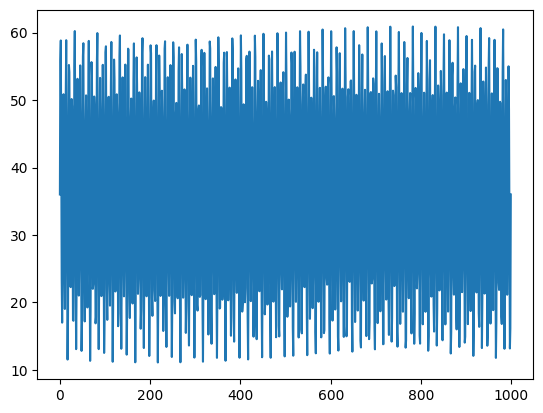

In [252]:
m =5*np.sin(2*np.pi*5*np.linspace(-10,10,1000))+30
n =20*np.sin(2*np.pi*8*np.linspace(-10,10,1000))+6 
x = m+n
plt.plot(x)


/home/omar71023/miniconda3/envs/torch/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/omar71023/miniconda3/envs/torch/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 1000.0)

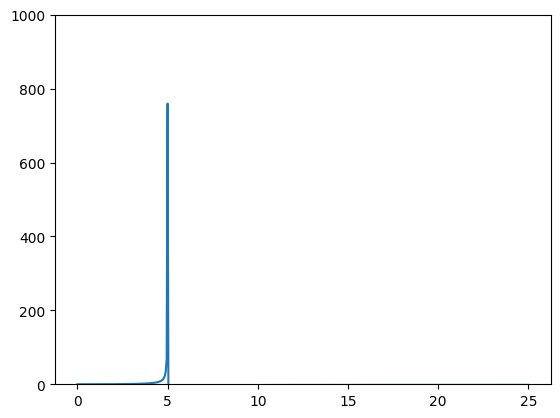

In [250]:
freqs = np.fft.rfftfreq(len(x), d=1/50)
fft_vals = np.fft.rfft(x)

plt.plot(freqs, fft_vals)
plt.ylim(0,1000)

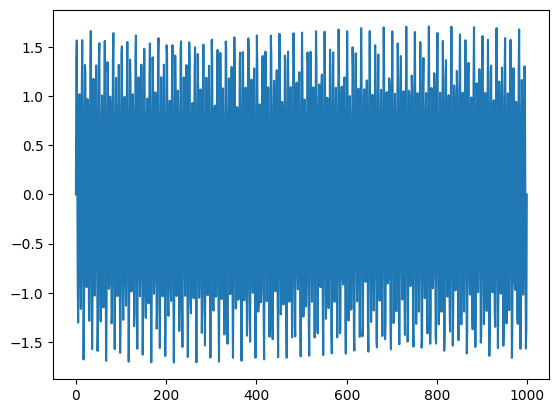

In [242]:
x-=x.mean()
x/=x.std()
plt.plot(x)

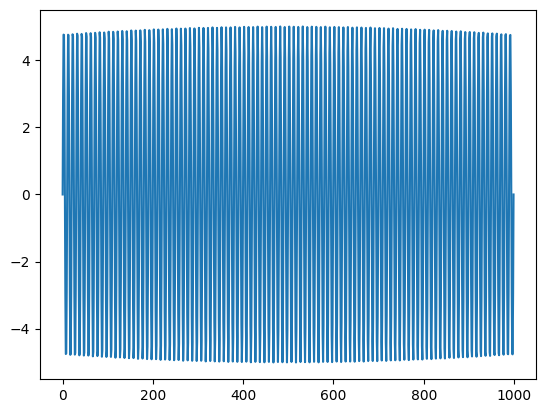

In [260]:

b, a = butter(4, [4, 6], btype='band', fs=50)
filtered = filtfilt(b, a, x, method='pad',padlen=999)
plt.plot(filtered)

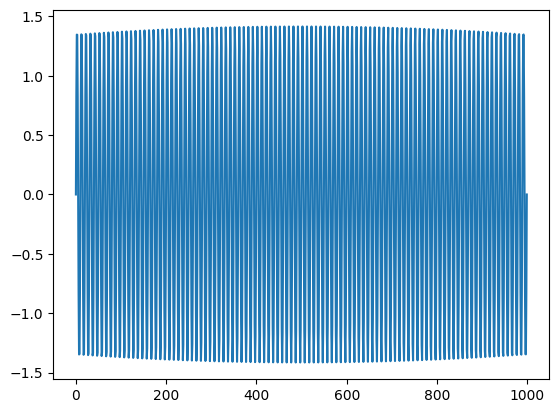

In [244]:
m-=m.mean()
m/=m.std()
plt.plot(m)

In [29]:
from scipy import signal



id                   4000
subject_id            S20
task                SSVEP
trial_session           8
trial                  10
label            Backward
Name: 3999, dtype: object


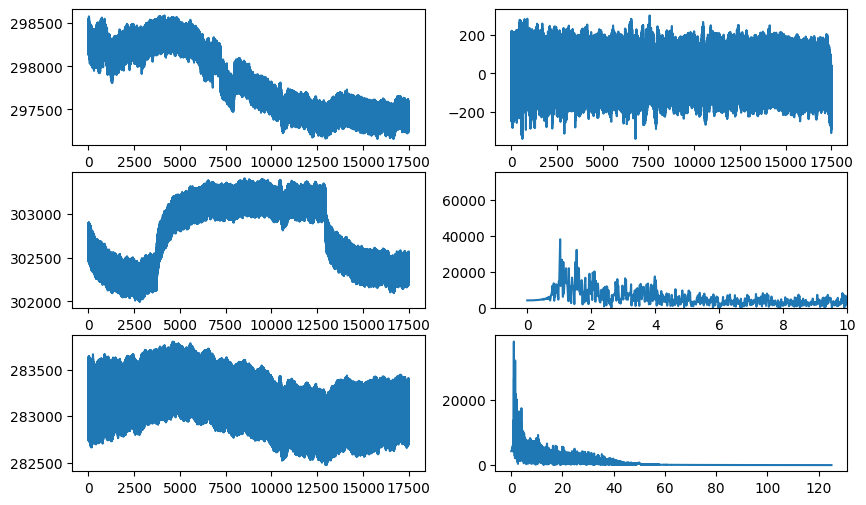

In [5]:
index = 3999   #((((2400 --> 4799)))) SSVEP   each consecutive ten trials are the same
ten_trials_df, one_trial_df, row = get_data(index)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))

axes[0,0].plot(ten_trials_df['PO7'])
axes[1,0].plot(ten_trials_df['PO8'])
axes[2,0].plot(ten_trials_df['OZ'])

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter(order, cutoff, btype='high', fs=fs)
    y = filtfilt(b, a, data, method='pad', padlen=1700)
    return y
filtered_OZ = butter_highpass_filter(ten_trials_df['PO7'], cutoff=0.4, fs=250)

axes[0,1].plot(filtered_OZ)

filtered_OZ = get_filtered(filtered_OZ, 1 , 40, fs=250, padlen=1000)
freqs, fft_vals = get_frequency(filtered_OZ)
axes[1,1].plot(freqs, fft_vals)
axes[1,1].set_xlim(-1,10)
axes[1,1].set_ylim(0,75000)

from scipy import signal  
fs = 250  # Sampling frequency (Hz)  
f0 = 50    # Notch frequency (Hz)  
Q = 30     # Quality factor (higher = narrower notch)  

# Design notch filter  
b, a = signal.iirnotch(50/125, Q)  
filtered_OZ = filtfilt(b,a, filtered_OZ, method='pad',irlen=1749)
b, a = signal.iirnotch(100/125, Q)  
filtered_OZ = filtfilt(b,a, filtered_OZ, method='pad',irlen=1749)

b, a = signal.iirpeak(8/125, Q, fs)  # Same params as iirnotch  

freqs, fft_vals = get_frequency(filtered_OZ)

axes[2,1].plot(freqs, fft_vals)

print(row)

In [6]:
#PipeLine:

# 1. High Pass to remove DC component with cuttoff = 0.5
# 2. Notch Filter at f = 50 hz
# 3. Notch Filter at f = 100 hz (harmonic)
# 4. IIRPeak or NarrowBandpass to Extract the signal


filtered = get_highpass_filtered(data, cutoff=0.5)
filtered = get_iirnotch_filtered(filtered, notchfreq=50)
filtered = get_iirnotch_filtered(filtered, notchfreq=100)



ValueError: The length of the input vector x must be greater than padlen, which is 1749.

Backward {'Left': 10, 'Right': 13, 'Forward': 7, 'Backward': 8}


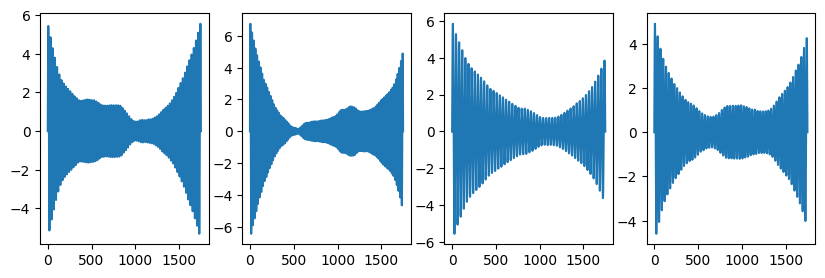

In [38]:
index = 2430  #((((2400 --> 4799)))) SSVEP   #2430 (battery drop peak drop) # 2448 (peak)
fs =250

# in case of stimulus extraction
ten_trials_df, one_trial_df, row = get_data(index)
data = one_trial_df['OZ']
print(row['label'], FREQUENCIES)
filtered = get_highpass_filtered(data, cutoff=0.5)
filtered = get_iirnotch_filtered(filtered, notchfreq=50)
data = get_iirnotch_filtered(filtered, notchfreq=100)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))

for i, label in enumerate(FREQUENCIES.keys()):
    low = FREQUENCIES[label] - fs/len(data)
    high = FREQUENCIES[label] + fs/len(data)

    #d = get_filtered(data, low, high)
    b, a = signal.iirpeak(FREQUENCIES[label]/125, Q)  # Same params as iirnotch
    d = filtfilt(b,a, data, method='pad',padlen=1749)


    axes[i].plot(d)

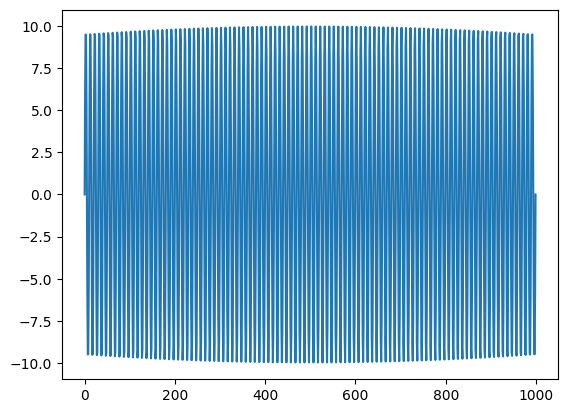

In [37]:
s = 10*np.sin(2*np.pi*5*np.linspace(-10,10,1000)) +20
#d = get_filtered(s, 5-0.05, 5+.05, padlen=999, fs=50)
b, a = signal.iirpeak(5/25, Q)  # Same params as iirnotch
d = filtfilt(b,a, s, method='pad',padlen=999)
plt.plot(d)

In [69]:
ten_trials_df[ten_trials_df['Validation']==0]

,Time,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,AccX,AccY,AccZ,Gyro1,Gyro2,Gyro3,Battery,Counter,Validation
2336,9.851297,262282.000000,259792.453125,319561.65625,349751.18750,267819.06250,256778.281250,233040.906250,242293.453125,-0.119141,0.837402,-0.549072,-0.335693,0.457764,0.396728,100.0,121447.0,0.0
2337,9.851298,262282.000000,259792.453125,319561.65625,349751.18750,267819.06250,256778.281250,233040.906250,242293.453125,-0.119141,0.837402,-0.549072,-0.335693,0.457764,0.396728,100.0,121448.0,0.0
2338,9.851300,262282.000000,259792.453125,319561.65625,349751.18750,267819.06250,256778.281250,233040.906250,242293.453125,-0.119141,0.837402,-0.549072,-0.335693,0.457764,0.396728,100.0,121449.0,0.0
2339,9.851301,262282.000000,259792.453125,319561.65625,349751.18750,267819.06250,256778.281250,233040.906250,242293.453125,-0.119141,0.837402,-0.549072,-0.335693,0.457764,0.396728,100.0,121450.0,0.0
2340,9.851302,262282.000000,259792.453125,319561.65625,349751.18750,267819.06250,256778.281250,233040.906250,242293.453125,-0.119141,0.837402,-0.549072,-0.335693,0.457764,0.396728,100.0,121451.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520,10.176472,261060.609375,259589.234375,321904.12500,350181.40625,269256.71875,256751.453125,233365.453125,242540.046875,-0.114990,0.833008,-0.552002,-0.366211,2.319336,0.976562,100.0,121631.0,0.0
2521,10.176472,261060.609375,259589.234375,321904.12500,350181.40625,269256.71875,256751.453125,233365.453125,242540.046875,-0.114990,0.833008,-0.552002,-0.366211,2.319336,0.976562,100.0,121632.0,0.0
2522,10.176472,261060.609375,259589.234375,321904.12500,350181.40625,269256.71875,256751.453125,233365.453125,242540.046875,-0.114990,0.833008,-0.552002,-0.366211,2.319336,0.976562,100.0,121633.0,0.0
2523,10.176472,261060.609375,259589.234375,321904.12500,350181.40625,269256.71875,256751.453125,233365.453125,242540.046875,-0.114990,0.833008,-0.552002,-0.366211,2.319336,0.976562,100.0,121634.0,0.0


In [5]:
FREQUENCIES = {
        'Left': 10,    # ---> 0
        'Right': 13,   # ---> 1
        'Forward': 7,  # ---> 2
        'Backward': 8  # ---> 3
    }

In [105]:
train_data = SSVEPDataset('train.csv')
idx = 1001  # 0, 1 have validation=0
df, metadata_row = train_data[idx]
df.head(10)

df.columns, metadata_row, FREQUENCIES[metadata_row['label']]

(Index(['Time', 'FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8', 'AccX',
        'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3', 'Battery', 'Counter',
        'Validation'],
       dtype='object'),
 id                  3402
 subject_id           S13
 task               SSVEP
 trial_session          5
 trial                  2
 label            Forward
 Name: 3401, dtype: object,
 7)

In [81]:
250/1750

0.14285714285714285

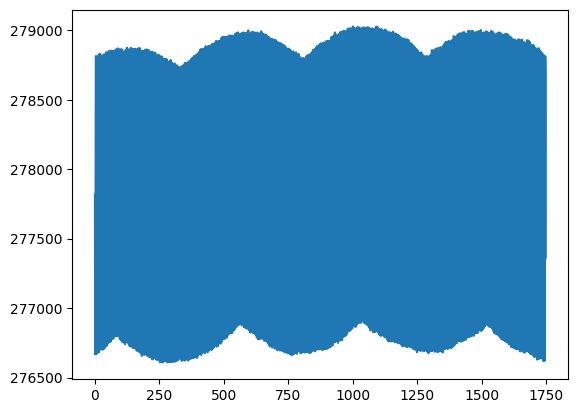

In [ ]:
plt.plot(df['OZ'].values - noise.values)

In [68]:
index = 2540  #((((2400 --> 4799)))) SSVEP   #2430 (battery drop peak drop) # 2448 (peak)
                                             # 2540 (increasing instead of decreasing OZ, PO7)
ten_trials_df, one_trial_df, row = get_data(index)


def normalize(x):
    x-= x.mean()
    x/= x.std()
    return x
t1 = 0
t2 = 7
fs =250
data = one_trial_df['OZ'][fs*t1:fs*t2]
#data = normalize(one_trial_df['OZ'])


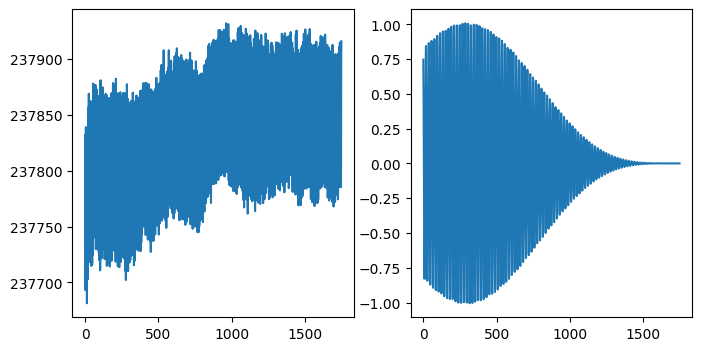

In [ ]:
from scipy.signal import butter, filtfilt
fs = 250  # Sampling frequency
def get_filtered(data, low, high):
    order = 5 # Filter order
    b, a = butter(order, [low, high], btype='band', fs=fs)
    filtered = filtfilt(b, a, data)
    return filtered

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

axes[0].plot(data)
axes[1].plot(filtered)


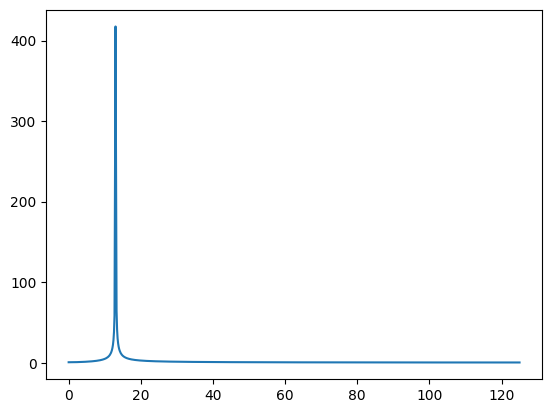

In [ ]:
import numpy as np
def to_frequency(filtered):
    freqs = np.fft.rfftfreq(len(filtered), d=1/fs)
    fft_vals = np.abs(np.fft.rfft(filtered))
    return freqs, fft_vals
freqs, fft_vals = to_frequency(filtered)
plt.plot(freqs, fft_vals)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt

# Filter design parameters
fs = 250  # Sampling frequency
lowcut = FREQUENCIES[metadata_row['label']]- .25  # Hz
highcut = FREQUENCIES[metadata_row['label']]+ .25 #40.0  # Hz
order = 400  # Filter order

# Design bandpass filter
#nyquist = 0.5 * fs
low = lowcut #/ nyquist
high = highcut #/ nyquist
b, a = butter(order, [low, high], btype='band', fs=fs)

# Select channels and create time vector
channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
eeg_subset = df[channels].copy()
time = np.arange(eeg_subset.shape[0]) / fs

# Apply filtering
for channel in channels:
    eeg_subset[f'{channel}_filt'] = filtfilt(b, a, eeg_subset[channel])

# Create figure with subplots
fig = plt.figure(figsize=(16, 18))
plt.suptitle('EEG Signals Analysis - Single Trial', fontsize=18, y=0.98)

# Create grid layout
gs = fig.add_gridspec(8, 4, width_ratios=[3,3,3,1], hspace=0.4, wspace=0.2)

for i, channel in enumerate(channels):
    # Time-domain plot (raw + filtered)
    ax1 = fig.add_subplot(gs[i, 0])
    ax1.plot(time, eeg_subset[channel], 'b', alpha=0.6, label='Raw')
    ax2 = fig.add_subplot(gs[i, 1])
    ax2.plot(time, eeg_subset[f'{channel}_filt'], 'r', label='Filtered (1-40Hz)')
    ax1.set_title(f'Channel {channel}', fontsize=12)
    ax1.set_ylabel('μV')
    ax1.grid(True, linestyle=':', alpha=0.7)
    ax2.set_title(f'Channel {channel}', fontsize=12)
    ax2.set_ylabel('μV')
    ax2.grid(True, linestyle=':', alpha=0.7)
    if i == 0:
        ax1.legend(loc='upper right')
        ax2.legend(loc='upper right')
    if i == len(channels) - 1:
        ax1.set_xlabel('Time (seconds)')
        ax2.set_xlabel('Time (seconds)')
    
    # Frequency-domain plot (PSD)
    ax3 = fig.add_subplot(gs[i, 2])
    freqs = np.fft.rfftfreq(len(eeg_subset), d=1/fs)
    fft_vals = np.abs(np.fft.rfft(eeg_subset[f'{channel}_filt']))**2
    ax3.semilogy(freqs, fft_vals, 'g')
    ax3.set_title('Power Spectrum')
    ax3.set_xlim(0, 60)
    ax3.grid(True, linestyle=':', alpha=0.7)
    
    # Mark stimulus frequencies
    for freq, color in zip([7, 8, 10, 13], ['m', 'c', 'r', 'b']):
        ax3.axvline(freq, color=color, linestyle='--', alpha=0.7)
        ax3.text(freq, np.max(fft_vals)*0.8, f'{freq}Hz', 
                 rotation=90, fontsize=8, color=color)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

/home/omar71023/miniconda3/envs/torch/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/omar71023/miniconda3/envs/torch/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/omar71023/miniconda3/envs/torch/lib/python3.12/site-packages/scipy/signal/_filter_design.py:2760: RuntimeWarning: invalid value encountered in scalar divide
  k_z = k * real(prod(fs2 - z) / prod(fs2 - p))


ValueError: The length of the input vector x must be greater than padlen, which is 2403.

In [13]:
import numpy as np
import pywt
from scipy.signal import iirnotch, filtfilt, butter, sosfiltfilt

def wavelet_denoise(eeg_data, wavelet='sym4', level=4, threshold_scale=1.0):
    """
    Apply wavelet denoising to EEG data
    
    Args:
        eeg_data: EEG array (channels × time)
        wavelet: Wavelet type (default: 'sym4')
        level: Decomposition level (default: 4)
        threshold_scale: Multiplier for threshold calculation
        
    Returns:
        Denoised EEG data
    """
    denoised = np.zeros_like(eeg_data)
    
    for ch in range(eeg_data.columns):
        # 1. Wavelet decomposition
        coeffs = pywt.wavedec(eeg_data[ch], wavelet, level=level)
        
        # 2. Calculate threshold (universal threshold method)
        sigma = np.median(np.abs(coeffs[-level])) / 0.6745  # MAD estimate
        threshold = threshold_scale * sigma * np.sqrt(2 * np.log(len(eeg_data[ch])))
        
        # 3. Apply soft thresholding to detail coefficients
        coeffs_thresh = [coeffs[0]]  # Keep approximation coefficients
        for i in range(1, len(coeffs)):
            coeffs_thresh.append(pywt.threshold(coeffs[i], threshold, mode='soft'))
        
        # 4. Reconstruct signal
        denoised[ch] = pywt.waverec(coeffs_thresh, wavelet)
    
    return denoised

def jitter_robust_filter(eeg_data, fs=250):
    """
    Jitter-robust filtering pipeline for EEG data
    
    Args:
        eeg_data: Raw EEG data (channels × time)
        fs: Sampling frequency (Hz)
    
    Returns:
        Filtered EEG data
    """
    # Wavelet denoising to reduce high-freq artifacts
    denoised = wavelet_denoise(eeg_data)  
    
    # Adaptive IIR notch filter
    b, a = iirnotch(50, 30, fs)
    notch_filtered = filtfilt(b, a, denoised)
    
    # Bandpass with phase compensation
    sos = butter(4, [5, 40], 'bandpass', fs=fs, output='sos')
    return sosfiltfilt(sos, notch_filtered)




In [16]:
filtered_data = jitter_robust_filter(df)

# Verify results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df['OZ'], 'b', alpha=0.6, label='Original')
plt.plot(filtered_data['OZ'], 'r', label='Filtered')
plt.legend()
plt.title('Channel OZ - Before/After Jitter-Robust Filtering')
plt.show()

TypeError: 'Index' object cannot be interpreted as an integer